### Questão 8

Qual fração de alunos de Mestrado/Doutorado (do total em cada programa) defendeu em 2017?

###### Definir DataFrame da Tabela de Discentes

In [4]:
import pandas as pd

csv_file = "discentes.csv"
discentes_raw = pd.read_csv(csv_file)
discentes_data = discentes_raw
discentes_data.rename(columns = {'nível': 'nivel'}, inplace=True)
# discentes_data.head()

###### Definir DataFrame da Tabela de Trabalhos

In [5]:
csv_file = "trabalhos.csv"
trabalhos_raw = pd.read_csv(csv_file)
trabalhos_data = trabalhos_raw
# trabalhos_data.head()

###### Definir colunas em comum entre as tabelas

In [6]:
common_columns = []
for column_name in discentes_data.columns: # Para cada coluna na tabela de discentes
    if(column_name in trabalhos_data): # Se a coluna existir na tabela de trabalhos
        common_columns.append(column_name) # Marcar como coluna em comum
common_columns

['ies', 'orientador', 'programa']

###### Reorganizar tabelas (retirar colunas desnecessárias para a questão)

In [7]:
# Utilizando variaveis auxiliares para mexer com as tabelas
aux_discentes_data = discentes_data.copy()
aux_trabalhos_data = trabalhos_data.copy()

# Manter somente as colunas necessárias nas tabelas
to_drop_in_discentes = []
for column_name in aux_discentes_data.columns: # Para cada coluna da tabela de discentes
    if(column_name not in common_columns and column_name != 'nivel'): # Selecionar colunas desncessárias
        to_drop_in_discentes.append(column_name)

aux_discentes_data = aux_discentes_data.drop(to_drop_in_discentes, 1) # Retirar colunas desnecessárias

to_drop_in_trabalhos = []
for column_name in aux_trabalhos_data.columns: # Para cada coluna da tabela de trabalhos
    if(column_name not in common_columns and column_name != 'data_defesa'): # Selecionar colunas desncessárias
        to_drop_in_trabalhos.append(column_name)

aux_trabalhos_data = aux_trabalhos_data.drop(to_drop_in_trabalhos, 1)  # Retirar colunas desnecessárias

###### Preparação de dados das tabelas para OUTER JOIN

In [8]:
# Dicionários para guardar strings definitivas (chaves) e as strings equivalentes (valores)
# Ex: PUC-Rio: [PUC-Rio, PUC - RIO, puc rj, puc rio]
possible_ies = {}
possible_programas = {}
possible_orientadores = {}

# Verificar se as strings sao equivalentes
def match_strings(str1, str2, error):
    diffs = 0
    aux_str1 = str1.replace(" ", "")
    aux_str2 = str2.replace(" ", "")
    for a, b in zip(aux_str1, aux_str2):
        if a != b:
            diffs += 1
            if(diffs > error):
                return 0
    return 1

# Tratar strings: tenta  verificar se a string pertence à algum grupo e adicioná-la à ele, ou criar um novo grupo para ela
def treat_string(c, column):
    if(not isinstance(c, str)):
        return c
    else:
        if(column == 'ies'):
            possible_group = possible_ies
            error = 10
        elif(column == 'programa'):
            possible_group = possible_programas
            error = 2
        elif(column == 'orientador'):
            possible_group = possible_orientadores
            error = 2

        # Para cada grupo, verifica se a string stual pertence aquele grupo (igual à uma string daquele grupo)
        for key in possible_group:
            if(c in possible_group[key]):
                return key
                break
            else:
                # Para cada string do grupo, verifica se a string atual é semelhante
                for possible_name in possible_group[key]:
                    if(match_strings(c, possible_name, error)):
                        possible_group[key].append(c);
                        return key
                        break
        # Se a string não se assemelha à nenhum grupo, cria um grupo novo para ela
        possible_group[c] = [c]
        return c
    
# Aplica o tratamento de strings às tabelas auxiliares
for column in aux_discentes_data:
    if(column in common_columns):
        aux_discentes_data[column] = aux_discentes_data[column].apply(treat_string, args=([column]))

for column in aux_trabalhos_data:
    if(column in common_columns):
        aux_trabalhos_data[column] = aux_trabalhos_data[column].apply(treat_string, args=([column]))

In [10]:
# aux_discentes_data.head()

In [11]:
# aux_trabalhos_data.head()

###### OUTER JOIN das tabelas auxiliares

In [12]:
# Mergeando as tabelas

merged_discentes_trabalhos = pd.merge(aux_discentes_data, aux_trabalhos_data, how='outer', on=common_columns)
# merged_discentes_trabalhos.head()

###### Definir dados necessários (total de alunos de mestrado/doutorado por programa e quais deles defenderam em 2017)

In [83]:
import array

# Definir quais são todos os diferentes programas
programas = []

for index, row in merged_discentes_trabalhos.iterrows():
    programa = row['programa']
    if(programa not in programas and isinstance(programa, str)):
        programas.append(programa)

# Definir o total de alunos de mestrado/doutorado em cada programa e quantos desses alunos defenderam em 2017
mestrado_por_programa = array.array('i', (0 for i in range(0, len(programas))))
doutorado_por_programa = array.array('i', (0 for i in range(0, len(programas))))
total_mestrado = array.array('i', (0 for i in range(0, len(programas))))
total_doutorado = array.array('i', (0 for i in range(0, len(programas))))

for index, row in merged_discentes_trabalhos.iterrows():
    programa = row['programa']
    nivel = row['nivel']
    defesa = row['data_defesa']
    if(isinstance(programa, str)):
        index = programas.index(programa)
        if(nivel == 'Mestrado'):
            total_mestrado[index] += 1 # Aluno de Mestrado nesse programa
            if(isinstance(defesa, str)):
                if(defesa[-4:] == '2017'):  # Aluno de Mestrado nesse programa que defendeu em 2017
                    mestrado_por_programa[index] += 1
        elif(nivel == 'Doutorado'):
            total_doutorado[index] += 1 # Aluno de Doutorado nesse programa
            if(isinstance(defesa, str)):
                if(defesa[-4:] == '2017'):  # Aluno de Doutorado nesse programa que defendeu em 2017
                    doutorado_por_programa[index] += 1

# Definir a fração de alunos de mestrado/doutorado que defenderam em 2017 por programa
_final_mestrado_por_programa = []
_final_doutorado_por_programa = []

for programa in programas:
    index = programas.index(programa)
    _final_mestrado_por_programa.append(float(mestrado_por_programa[index] / total_mestrado[index] * 100))
    _final_doutorado_por_programa.append(float(doutorado_por_programa[index] / total_doutorado[index] * 100))
         
# Refatorar os nomes dos programas (break lines entre nome do programa e número do programa)
_final_programas = []
        
def treat_x_labels(labels):
    for label in labels:
        index = label.index('(');
        nome_programa = label[:index]
        num_programa = label[index:]
        _final_programas.append(nome_programa + '\n' + num_programa)

treat_x_labels(programas)

###### Agrupar os dados em um DataFrame para a vizualização

In [84]:
# Definir as colunas do data frame
_new_columns = ['programas', 'nivel', 'fracao_alunos']

# Criar data
_new_data = []

# Adicionar dados a data
for programa in _final_programas:
    index = _final_programas.index(programa)
    _new_data.append([programa, 'Mestrado', _final_mestrado_por_programa[index]])
    _new_data.append([programa, 'Doutorado', _final_doutorado_por_programa[index]])

# Criar data frame com as colunas e a data
_new_table = pd.DataFrame(data = _new_data, columns = _new_columns)

###### Gráfico para vizualização dos dados

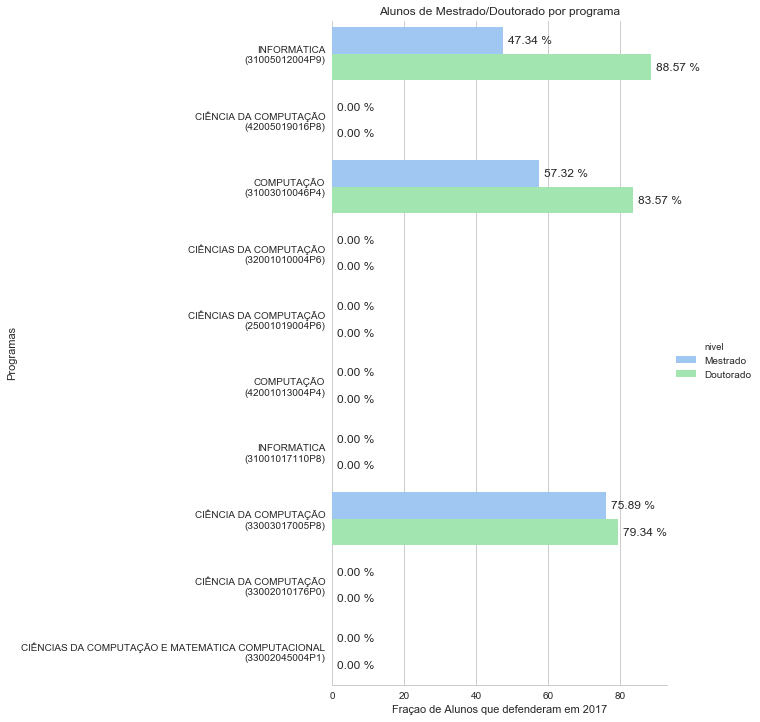

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt

# Preparar gráfico de barras para vizualização
sns.set(style="whitegrid")

# Adicionar dados ao gráfico, definir tipo do gráfico e algumas definições de estilo
g = sns.factorplot(x="fracao_alunos", y="programas", hue="nivel", data=_new_table,
                   size=10, kind="bar", palette="pastel")

g.despine(left=True)

# Adicionar labels aos eixos
g.set_xlabels("Fraçao de Alunos que defenderam em 2017")
g.set_ylabels("Programas")

# Adionar titulo ao grafico
axes = g.axes.flatten()
axes[0].set_title("Alunos de Mestrado/Doutorado por programa")
# g.set_xticklabels(rotation=30)

# Anotações da porcentagem ao lado das barras
for i, p in enumerate(axes[0].patches):
    axes[0].annotate("{:.{}f} %".format( p.get_width(), 2 ),
                (p.get_x() + p.get_width(), p.get_y() + 0.4),
                xytext=(5, 10), textcoords='offset points')

sns.plt.show()

### Questão 9

Quantos artigos de periódico/trabalhos em anais foram publicados por cada programa em 2017?

###### Definir DataFrame da Tabela de Produção

In [54]:
import pandas as pd

csv_file = "producao.csv"
producao_raw = pd.read_csv(csv_file)
producao_data = producao_raw
# producao_data.head()

###### Analisando como separar artigos de periódico de trabalhos em anais

In [51]:
count_anais_titulo = 0
count_periodico = 0
count_both = 0
count_any = 0
for index, row in producao_data.iterrows():
    if(isinstance(row['periodico'], str) and isinstance(row['anais_titulo'], str)):
        count_both += 1
    if(isinstance(row['periodico'], str)):
        count_periodico += 1
    if(isinstance(row['anais_titulo'], str)):
        count_anais_titulo += 1
    if(not isinstance(row['periodico'], str)  and not isinstance(row['anais_titulo'], str)):
        count_any += 1

print('Total de linhas que possuem anais_titulo: ' + str(count_anais_titulo))
print('Total de linhas que possuem periodico: ' + str(count_periodico))
print('Total de linhas que possuem os dois: ' + str(count_both))
print('Total de linhas que não possuem nenhum dos dois: ' + str(count_any))
producao_data.shape

Total de linhas que possuem anais_titulo: 1526
Total de linhas que possuem periodico: 747
Total de linhas que possuem os dois: 0
Total de linhas que não possuem nenhum dos dois: 619


(2892, 35)

###### Reorganizar tabelas (retirar colunas desnecessárias para a questão)

In [55]:
# Utilizando uma variavel auxiliar para mexer com a tabela
aux_producao_data = producao_data.copy()

necessary_columns = ['anais_titulo', 'periodico', 'programa', 'ano']

# Manter somente as colunas necessárias na tabela
to_drop_in_producao = []
for column_name in aux_producao_data.columns: # Para cada coluna da tabela de discentes
    if(column_name not in necessary_columns): # Selecionar colunas desncessárias
        to_drop_in_producao.append(column_name)

aux_producao_data = aux_producao_data.drop(to_drop_in_producao, 1) # Retirar colunas desnecessárias

In [57]:
# aux_producao_data.head()

###### Definir dados necessários (total de artigos de periodico/trabalhos em anais por programa em 2017)

In [64]:
import array

# Definir quais são todos os diferentes programas
programas = []

for index, row in aux_producao_data.iterrows():
    programa = row['programa']
    if(programa not in programas and isinstance(programa, str)):
        programas.append(programa)

# Definir o total de artigos de periodico/trabalhos em anais em cada programa em 2017
periodico_por_programa = array.array('i', (0 for i in range(0, len(programas))))
anais_por_programa = array.array('i', (0 for i in range(0, len(programas))))

for index, row in aux_producao_data.iterrows():
    programa = row['programa']
    anais = row['anais_titulo']
    periodico = row['periodico']
    if(isinstance(programa, str)):
        index = programas.index(programa)
        if(isinstance(anais, str)):
            anais_por_programa[index] += 1
        elif(isinstance(periodico, str)):
            periodico_por_programa[index] += 1
            
# # Refatorar os nomes dos programas (break lines entre nome do programa e número do programa)
_final_programas = []
        
def treat_x_labels(labels):
    for label in labels:
        index = label.index('(');
        nome_programa = label[:index]
        num_programa = label[index:]
        _final_programas.append(nome_programa + '\n' + num_programa)

treat_x_labels(programas)

###### Agrupar os dados em um DataFrame para a vizualização

In [86]:
# Definir as colunas do data frame
_new_columns = ['programa', 'tipo', 'total_tipo']

# Criar data
_new_data = []

# Adicionar dados a data
for programa in _final_programas:
    index = _final_programas.index(programa)
    _new_data.append([programa, 'Artigo de Periodico', periodico_por_programa[index]])
    _new_data.append([programa, 'Trabalho em Anais', anais_por_programa[index]])

# Criar data frame com as colunas e a data
_new_table = pd.DataFrame(data = _new_data, columns = _new_columns)

###### Gráfico para vizualização dos dados

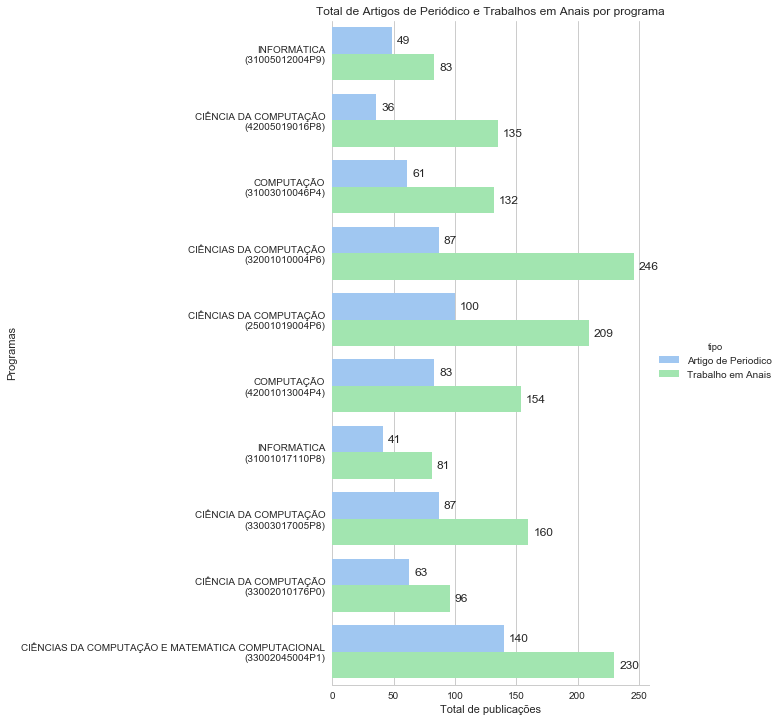

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt

# Preparar gráfico de barras para vizualização
sns.set(style="whitegrid")

# Adicionar dados ao gráfico, definir tipo do gráfico e algumas definições de estilo
g = sns.factorplot(x="total_tipo", y="programa", hue="tipo", data=_new_table,
                   size=10, kind="bar", palette="pastel")

g.despine(left=True)

# Adicionar labels aos eixos
g.set_xlabels("Total de publicações")
g.set_ylabels("Programas")

# Adionar titulo ao grafico
axes = g.axes.flatten()
axes[0].set_title("Total de Artigos de Periódico e Trabalhos em Anais por programa")
# g.set_xticklabels(rotation=30)

# Anotações da porcentagem ao lado das barras
for i, p in enumerate(axes[0].patches):
    axes[0].annotate("{:.{}f}".format( p.get_width(), 0 ),
                (p.get_x() + p.get_width(), p.get_y() + 0.4),
                xytext=(5, 10), textcoords='offset points')

sns.plt.show()